In [52]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# The Max-Cut Problem

Given an undirected graph $G=(V,E)$ with $n=∣V∣$ vertices (and $m=∣E∣$ edges), the Max-Cut problem asks for a partition of the vertex set into two disjoint subsets $S$ and $V\setminus S$ that maximises the number of edges whose endpoints lie on opposite sides of the partition. Picture placing the vertices in $S$ on one side and those in $V\setminus S$ on the other; the “cut” consists of every edge running between the two sides, and the optimal solution has the largest number of such edges.

We can represent a solution (or "cut") to the Max-Cut problem using a bitstring, where $0$ and $1$ denote different sets. Below, we define functions to convert an integer to its bitstring.


In [53]:
def int2bits(k, n):
    return format(k, f"0{n}b")

We'll be using `NetworkX` to generate graphs in this workshop.

You can generate a random graph with $n$ using the `gnp_random_graph` function.  

In [54]:
n = 7 # number of nodes
edge_prob = 0.5 # probability of edge creation

G = nx.gnp_random_graph(n, edge_prob, seed=42) # create a random graph using networkx


We can retrieve the number of nodes  in `G` using its `get_number_of_nodes` method. The  `cut_value` function below uses the `edges` method to iterate over the edges of `G`,  where tuple `(u, v)`  denotes a connection between vertices `u` and `v`.

`NetworkX` also provides basic graph visualisation, which we use  to define `plot_graph` to visualise Max-cut solutions.

In [55]:
def cut_value(bitstring, G):
    z = [int(b) for b in bitstring]
    return sum(z[u] != z[v] for u, v in G.edges())/2


def plot_graph(G, cut = None):
    pos = nx.spring_layout(G, seed=17)
    plt.figure(figsize=(5, 5))

    if cut != None:
        bits = [int(b) for b in cut]
        part0 = [v for v in G.nodes if bits[v] == 0]
        part1 = [v for v in G.nodes if bits[v] == 1]
        cut_edges = [(u, v) for u, v in G.edges if bits[u] != bits[v]]
        same_edges = [(u, v) for u, v in G.edges if bits[u] == bits[v]]
        nx.draw_networkx_nodes(G, pos, nodelist=part0, node_color='tab:blue', label='0')
        nx.draw_networkx_nodes(G, pos, nodelist=part1, node_color='tab:orange', label='1')
        nx.draw_networkx_edges(G, pos, edgelist=same_edges, edge_color='gray')
        nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color='red', style='dashed', width=2)
    else:
        nx.draw_networkx_nodes(G, pos) 
        nx.draw_networkx_edges(G, pos, width=2)
    
    nx.draw_networkx_labels(G, pos)
    if cut != None:
        plt.title(f"Max-Cut Solution: {cut}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Can you find the optimal cut to `G`?

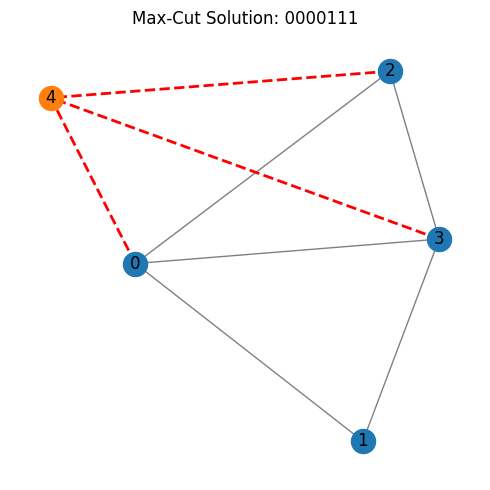

Cut value: 1.5


In [56]:
n = 5
edge_prob = 0.7
G = nx.gnp_random_graph(n, edge_prob, seed = 42)
cut = '0000111'
plot_graph(G, cut = cut)
print(f'Cut value: {cut_value(cut, G)}')

Max-Cut is an interesting problem in the context of quantum computing. For one,  it's a simple problem to state that is computationally tough. It belongs to the NP-hard complexity class, meaning that while it is easy to compute the value of a given cut, it is widely held that an algorithm that can find an optimum cut in polynomial time does not exist. It's also the case that many optimisation tasks can be framed as a Max-cut problem, such as electrical circuit layouts, spin models and even portfolio rebalancing. 

To understand how the Max-cut problem's hardness scales with the number of nodes $n$, we can compute how many solutions we need to query on average before encountering the optimal cut value.

Even after finding a globally optimal cut, verifying this generally still requires evaluating the entire solution space, which is of size $2^n$.

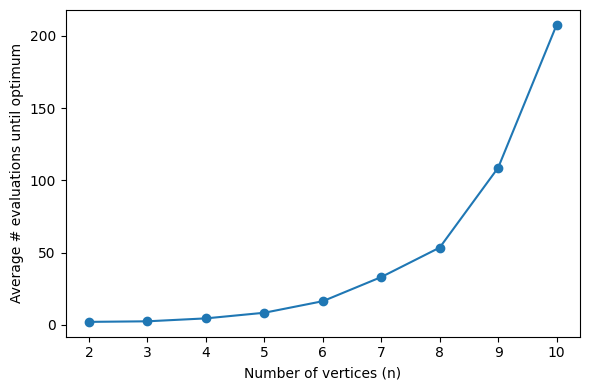

In [57]:
def first_optimum(n, G):
    best_val, evals_to_best, best_bs = -1, 0, None
    for i in range(2**n):
        bs = int2bits(i, n)
        val = cut_value(bs, G)
        if val > best_val:
            best_val, evals_to_best, best_bs = val, i + 1, bs
    return evals_to_best, best_val, best_bs

n_min, n_max = 2, 10
samples_per_n = 50
edge_prob = 0.5

avg_evals = []
ns = list(range(n_min, n_max + 1))

for n in ns:
    evals_list = []
    for _ in range(samples_per_n):
        G = nx.gnp_random_graph(n, edge_prob)
        if G.number_of_edges() == 0:
            continue
        evals, _, _ = first_optimum(n, G)
        evals_list.append(evals)
    if evals_list:
        avg_evals.append(sum(evals_list) / len(evals_list))
    else:
        avg_evals.append(float('nan'))

plt.figure(figsize=(6,4))
plt.plot(ns, avg_evals, marker='o')
plt.xlabel("Number of vertices (n)")
plt.ylabel("Average # evaluations until optimum")
plt.tight_layout()
plt.show()

# Quantum Approximate Optimisation Algorithm (QAOA)

The **Quantum Approximate Optimisation Algorithm** (QAOA) is a hybrid quantum–classical routine for tackling combinatorial optimisation problems on near-term quantum devices.
A problem instance is encoded in a **cost Hamiltonian** $C(\mathbf Z)$.  The algorithm evolves an $n$-qubit register by alternating **phase-shift** and **mixing** unitaries whose angles are classical parameters.  A classical optimiser iteratively updates those parameters to minimise the expectation value $\langle C(\mathbf Z)\rangle$, thereby increasing the probability of measuring an optimal (or near-optimal) solution.

---

## Algorithm overview

### 1. Initial state

Start from the uniform superposition

$$
\ket{\psi_0}\;=\;\frac{1}{\sqrt{2^{\,n}}}\sum_{x\in\{0,1\}^n}\ket{x},
$$

where $n$ is the number of qubits.

### 2. Phase-shift unitary

$$
U_P(\gamma)\;=\;\exp\!\bigl(-i\gamma\,C(\mathbf Z)\bigr),
$$

with tunable parameter $\gamma$.  The operator $C(\mathbf Z)$ (a function of Pauli-Zs) assigns the cost to each computational-basis state. Consequently, $U_P$ shifts the phase of basis states proportional to their assigned costs.

### 3. Mixing unitary

$$
U_M(\beta)\;=\;\exp\!\Bigl(-i\beta\sum_{i=1}^{n}X_i\Bigr),
$$

where $\beta$ is tunable and $X_i$ is the Pauli-$X$ (NOT) gate acting on qubit $i$.

### 4. Hybrid loop

Choose a circuit depth $p$.  For layers $k=1,\dots,p$:

1. **Prepare**

   $$
   \ket{\psi(\boldsymbol\gamma,\boldsymbol\beta)} \;=\;
   U_M(\beta_k)\,U_P(\gamma_k)\,\dots\,U_M(\beta_1)\,U_P(\gamma_1)\,\ket{\psi_0}.
   $$

2. **Evaluate** Sample the circuit to estimate the expectation
   $\langle C(\mathbf Z)\rangle$ (the average measured cost).

3. **Optimise** Update the parameter set
   $\{\gamma_1,\dots,\gamma_p,\;\beta_1,\dots,\beta_p\}$ with a classical optimiser.

Stop when $\langle C(\mathbf Z)\rangle$ converges (or after a chosen iteration limit).

## Programming QAOA for Max-Cut

In this section you will complete function that will together produce a QAOA circuit to solve the max-cut problem for any graph $G$.

Below we import the required classes from Qiskit for circuit construction. `Parameter` and `ParameterVector` allow us to build circuits with classically-tunable parameters that can be modified from shot-to-shot without needing to re-transpile the circuit.

In [58]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector

### Step 1: Preparing the initial state

### Exercise 2.1

Complete **the function below** so that it takes a `QuantumCircuit` and a `networkx` graph as inputs and returns a circuit that prepares a uniform superposition over all $n$ qubits.

> **Note:** We will reuse this function (and others) to build the full QAOA circuit, so do **not** add measurement operations here.

In [59]:
def qaoa_initial_state(qc, G):
    # solution
    n = G.number_of_nodes()
    for q in range(n):
        qc.h(q)
    return qc

### Step 2: Cost-dependent phase-shift

In QAOA the operator $C(\mathbf Z)$ encodes the cost of every candidate solution—but **how** is that cost written in the qubit basis?

---

#### 2.1 Binary variables as Pauli-$Z$ eigenvalues

A computational‐basis measurement of a single qubit collapses it to

$$
\lvert 0\rangle=\begin{pmatrix}1\\0\end{pmatrix},
\qquad
\lvert 1\rangle=\begin{pmatrix}0\\1\end{pmatrix}.
$$

Both are eigenstates of the Pauli-$Z$ operator

$$
\hat Z=\begin{pmatrix}1&0\\0&-1\end{pmatrix}, \qquad
\hat Z\ket{0}=+\,\ket{0},\;\;
\hat Z\ket{1}=-\,\ket{1}.
$$

Thus $\hat Z$ is the quantum analogue of a binary variable that takes values $\{+1,-1\}$.
For a classical bit $z_i\in\{0,1\}$ carried by qubit $i$,

$$
z_i=\frac{1-\langle\hat Z_i\rangle}{2}
\;\Longleftrightarrow\;
\hat Z_i = 1-2z_i.
$$

* $z_i=0 \;\Rightarrow\; \ket{0}$ with $\hat Z_i=+1$.
* $z_i=1 \;\Rightarrow\; \ket{1}$ with $\hat Z_i=-1$.

---

#### 2.2 Expressing the Max-Cut cost

For an edge $(i,j)$ in graph $G$ the cut value of that edge is

$$
z_i\oplus z_j \;=\; z_i + z_j - 2z_i z_j .
$$

Summing over all edges and substituting $\hat Z_i = 1-2z_i$ gives the **quantum cost operator**

$$
\boxed{\;
\hat C(\mathbf Z)\;=\;\frac12\sum_{(i,j)\in E}\bigl(1-\hat Z_i\hat Z_j\bigr)\;} .
$$

---

#### 2.3 From operator to phase-shift unitary

Because all terms in $\hat C(\mathbf Z)$ commute, its exponential factorises edge-by-edge:

$$
U_P(\gamma_k)
= \exp\!\bigl[-\,i\gamma_k\,\hat C(\mathbf Z)\bigr]
= \prod_{(i,j)\in E}\exp\!\Bigl[-\,i\frac{\gamma_k}{2}\bigl(1-\hat Z_i\hat Z_j\bigr)\Bigr].
\tag{1}
$$

For each edge $(i,j)$,

$$
\exp\!\Bigl[-\,i\frac{\gamma}{2}\bigl(1-\hat Z_i\hat Z_j\bigr)\Bigr]
= e^{-i\gamma/2}\;
\underbrace{\exp\!\Bigl(+\,i\frac{\gamma}{2}\,\hat Z_i\hat Z_j\Bigr)}_{\displaystyle R_{ZZ}^{(i,j)}(\gamma)} .
$$

The global phase $e^{-i\gamma/2}$ is irrelevant to measurement statistics, so in practice we implement only

$$
\boxed{\;
R_{ZZ}^{(i,j)}(\gamma)\;=\;
\exp\!\Bigl(+\,i\frac{\gamma}{2}\,\hat Z_i\hat Z_j\Bigr)} ,
$$

often called an **$R_{ZZ}$ gate**, for every edge of $G$.


### Exercise 2.2

Complete **the function below** so that it adds an $R_{ZZ}^{(i,j)}(\gamma)$ gate for every edge $(i,j)$ in the graph $G$.

* In Qiskit the call is

  ```python
  qc.rzz(gamma, i, j)
  ```

  where `i` and `j` are the qubit indices.

* Iterate over the graph’s edges with `G.edges()`.

The finished function should return the modified `QuantumCircuit`.


In [60]:
def qaoa_cost_unitary(qc, G, gamma):
    # solution
    for (i, j) in G.edges():
        qc.rzz(2 * gamma, i, j)
    return  qc

### Step 3: Amplitude mixing

To implement the mixing unitary

$$
U_M(\beta)\;=\;\exp\!\Bigl(-i\beta\sum_{i=1}^{n} X_i\Bigr),
$$

first note that the Pauli-$X$ operators acting on different qubits commute.
The exponential therefore factorises into single-qubit rotations:

$$
U_M(\beta)\;=\;\prod_{i=1}^{n}\exp\!\bigl(-i\beta X_i\bigr)
\;=\;\prod_{i=1}^{n} R_x^{(i)}(2\beta),
$$

where

$$
R_x(\theta)\;=\;\exp\!\Bigl(-\,i\frac{\theta}{2}\,X\Bigr)
$$

is a rotation about the $X$-axis.

In Qiskit this is realised by applying `qc.rx(2 * beta, i)` to every qubit $i$.

### Exercise 2.3

Complete the function below using the **gate-level decomposition** of the mixing unitary $U_M$.

For each qubit $j$ apply an $R_x$ rotation of angle $2\beta$:

```python
qc.rx(theta, j)   # theta is the rotation angle; j is the qubit index
```

In [61]:
def qaoa_mixing_unitary(qc, G, beta):
    # solution
    n = G.number_of_nodes()
    for q in range(n):
        qc.rx(2 * beta, q)
    return qc

### Putting it All Together

With the three functions complete we can now build the full QAOA circuit.

In [62]:
from qiskit.circuit import ParameterVector

def make_qaoa_circuit(qc, layers, G):

    gammas = ParameterVector("gammas", length = layers)
    betas = ParameterVector("betas", length = layers)

    qc = qaoa_initial_state(qc, G)
    
    for layer in range(layers):
        qc = qaoa_cost_unitary(qc, G, gammas[layer])
        qc = qaoa_mixing_unitary(qc, G, betas[layer])
            
    return qc, list(gammas) + list(betas)

Try visualising the circuit with different graphs and numbers of layers.

In [63]:
n = 4
n_solutions = 2**n
G = nx.gnp_random_graph(n, 0.5, seed=42)

qc = QuantumCircuit(n)

layers = 2

qc, _ = make_qaoa_circuit(qc, layers, G)
qc.measure_all()

qc.draw(fold = -1) # fold -1 keeps the circuit on the same line

┌───┐                                    ┌────────────────┐                                                      ┌────────────────┐                   ░ ┌─┐         
   q_0: ┤ H ├─■─────────────────■────────────────┤ Rx(2*betas[0]) ├───────────────────■─────────────────■────────────────┤ Rx(2*betas[1]) ├───────────────────░─┤M├─────────
        ├───┤ │                 │                └────────────────┘┌────────────────┐ │                 │                └────────────────┘┌────────────────┐ ░ └╥┘┌─┐      
   q_1: ┤ H ├─┼─────────────────┼─────────────────■────────────────┤ Rx(2*betas[0]) ├─┼─────────────────┼─────────────────■────────────────┤ Rx(2*betas[1]) ├─░──╫─┤M├──────
        ├───┤ │ZZ(2*gammas[0])  │                 │ZZ(2*gammas[0]) ├────────────────┤ │ZZ(2*gammas[1])  │                 │ZZ(2*gammas[1]) ├────────────────┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├─■─────────────────┼─────────────────■────────────────┤ Rx(2*betas[0]) ├─■─────────────────┼─────────────────■────────────────┤ Rx(2*betas[1]) ├─░──╫──╫─┤M├───
        ├───┤                   │ZZ(2*gammas[0]) ┌────────────────┐└────────────────┘                   │ZZ(2*gammas[1]) ┌────────────────┐└────────────────┘ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├───────────────────■────────────────┤ Rx(2*betas[0]) ├─────────────────────────────────────■────────────────┤ Rx(2*betas[1]) ├───────────────────░──╫──╫──╫─┤M├
        └───┘                                    └────────────────┘                                                      └────────────────┘                   ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                 0  1  2  3

### Variational  Optimisation

With `make_qaoa_circuit` implemented we can now close our hybrid quantum-class optimisation loop!

The `qaoa_objective_function` takes an array of $2 p$ classical parameters, the first specifying $(\gamma_1, \dots, \gamma_p)$ and the second $(\beta_1, \dots, \beta_p)$. The circuit is run with those parameters for `nshots` shots and the collected results are parsed using the classical `cut_value` function and average to obtain one computation of the QAOA objective function. As we are using SciPy's `minimize` function and we want to maximise the cut, the expectation value is negated before returning it to the optimiser.

**Note:** We reverse the bitstring keys in the Qiskit results (`bs[::-]`) as our `int2bits` function converts into *big-endian* binary strings (qubit zero is on the right), while Qiskit uses *little-endian* ordering (qubit zero on the left). 

In [64]:
def qaoa_objective_function(input_parameters, qc, circuit_parameters, G, backend, shots):

    bound_qc = qc.assign_parameters(dict(zip(circuit_parameters, input_parameters)))

    job = backend.run(bound_qc, shots = shots)
    counts =  job.result().get_counts()
    exp_val = np.sum([cut_value(bs[::-1], G) * c for  bs, c in counts.items()])/shots
    return -exp_val

Trying running the optimisation loop varying the number of shots and circuit layers (`p`). We expect that, with enough shots per expectation value computation, the objective function value should decrease as `p` increases.

In [65]:
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

backend  = AerSimulator()

shots = 64
layers = 4
G = nx.gnp_random_graph(10, 0.5, seed = 42)

qc = QuantumCircuit(G.number_of_nodes())
qc, circuit_parameters = make_qaoa_circuit(qc, layers, G)

qc.measure_all()

initial_parameters = layers * [0.5, 1.5]
opt_result = minimize(qaoa_objective_function, initial_parameters, args = (qc, circuit_parameters, G, backend, shots), method = "COBYLA", options = {"maxiter":200})
print(opt_result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.984375
       x: [ 4.758e-01  2.534e+00  5.026e-01  1.540e+00  5.380e-01
            1.607e+00  4.586e-01  1.436e+00]
    nfev: 83
   maxcv: 0.0


Let's take a look at the most-frequently occurring solution:

{'0001111011': 1, '0111110101': 1, '0000110100': 1, '0111110000': 1, '0100011110': 1, '1100011011': 1, '1111010100': 1, '0101111110': 1, '0011001011': 1, '1010011010': 1, '0000011100': 1, '0000011000': 1, '0011011000': 1, '0010011010': 1, '1100010011': 1, '1010000111': 1, '1010100011': 2, '1011111010': 1, '0110101011': 1, '0110010111': 1, '0100111110': 1, '0011100011': 1, '1111110100': 1, '1000111100': 1, '1110000110': 1, '0101011011': 1, '1100100011': 1, '1001011110': 1, '1011111110': 1, '1111110000': 1, '0011100110': 1, '0001000000': 1, '1100001011': 1, '1001000010': 1, '0100001110': 1, '1110000011': 1, '1011101110': 1, '0111011001': 1, '0111110011': 1, '1000101111': 1, '0100011010': 1, '1010100000': 1, '1000001111': 1, '1101011100': 1, '1000000100': 1, '0011011100': 1, '0111111000': 1, '1100100100': 1, '1001100001': 1, '1000001011': 1, '1110100011': 2, '1000101110': 1, '0101110011': 1, '1010011101': 1, '0011100101': 1, '0001101111': 1, '0010100001': 1, '1000001100': 1, '0110110001':

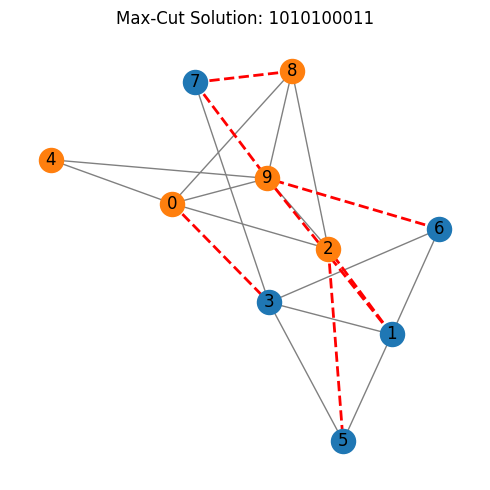

In [66]:
n = G.number_of_nodes()
gammas, betas = np.split(opt_result.x, 2)

bqc = qc.assign_parameters(dict(zip(circuit_parameters, opt_result.x)))

counts = backend.run(bqc, shots = shots).result().get_counts()

print(counts)

most_common = max(counts, key=counts.get)
plot_graph(G, most_common)


The cell below visualises how the QAOA parameters found by the optimiser reshape the output distribution. Starting from the uniform superposition (every bit-string equally likely), we compute the exact statevector of the optimised circuit and aggregate both the initial and final probabilities by their Max-Cut value. 

Plotting these side-by-side, if the QAOA parameters have been successfully optimised, the probability mass with move from the most common cut-values toward those that cut more edges.

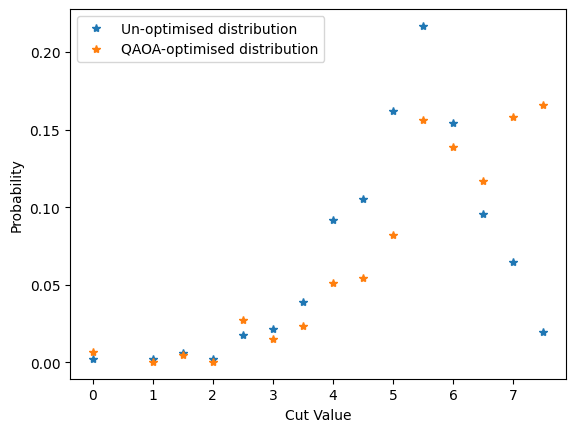

In [67]:
from qiskit.quantum_info import Statevector

bqc.remove_final_measurements()


final_probability= Statevector.from_instruction(bqc).probabilities()

starting_probability = np.array(2**n * [1/2**n])
cut_values = np.array([cut_value(int2bits(i, n)[::-1], G) for i in range(2**n)])

unique_cuts, inverse = np.unique(cut_values, return_inverse=True)
agg_prob_final = np.zeros_like(unique_cuts, dtype=float)
agg_prob_start = np.zeros_like(unique_cuts, dtype=float)
np.add.at(agg_prob_final, inverse, final_probability)
np.add.at(agg_prob_start, inverse, starting_probability)


plt.plot(unique_cuts,  agg_prob_start, '*', label = 'Un-optimised distribution')
plt.plot(unique_cuts,  agg_prob_final, '*', label = 'QAOA-optimised distribution')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("Cut Value")
plt.show()